# Feature engineering
En primer lugar creo que es conveniente guardar los datos ya usados en el template inicial, para que no haya necesidad de calcularlos cada vez que se carga el notebook.

En segundo lugar, se propone este notebook como un espacio de experimentacion de creacion de features, para tener mejor ordenada cada tarea.

**Nota importante** Este notebook se encuentra cerrado. Para trabajar con los resultados del mismo, copiar y ejecutar la ultima celda, donde se encuentran todos los pasos de codigo.
***

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
# This will allow you to see all column names & rows when you are doing .head(). None of the column name will be truncated.
# source: https://stackoverflow.com/questions/49188960/how-to-show-all-of-columns-name-on-pandas-dataframe

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [4]:
# source: https://gist.github.com/rozanecm/38f2901c592bdffc40726cb0473318cf
# Function which plays a beep of given duration and frequency.
# Useful for when executing things that need a while to finish, to get notified.
import os
def beep(duration = 1, freq = 1500):
    """ play tone of duration in seconds and freq in Hz. """
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))

In [5]:
train = pd.read_csv('../data/train.csv', dtype={'tipodepropiedad':'category', 'ciudad':'category', 'provincia':'category', 'id':'int32', 'antiguedad':'float16', 'habitaciones':'float16', 'garages':'float16', 'banos':'float16', 'metroscubiertos':'float16', 'metrostotales':'float16', 'idzona':'float16', 'lat':'float16', 'lng':'float16', 'gimnasio':'bool', 'usosmultiples':'bool', 'piscina':'bool', 'escuelascercanas':'bool', 'centroscomercialescercanos':'bool'}, parse_dates=['fecha'])
test = pd.read_csv('../data/test.csv', dtype={'tipodepropiedad':'category', 'ciudad':'category', 'provincia':'category', 'id':'int32', 'antiguedad':'float16', 'habitaciones':'float16', 'garages':'float16', 'banos':'float16', 'metroscubiertos':'float16', 'metrostotales':'float16', 'idzona':'float16', 'lat':'float16', 'lng':'float16', 'gimnasio':'bool', 'usosmultiples':'bool', 'piscina':'bool', 'escuelascercanas':'bool', 'centroscomercialescercanos':'bool'}, parse_dates=['fecha'])
sample_submission = pd.read_csv('../data/ejemploRespuesta.csv')

In [6]:
rescued_coords = pd.read_csv('../data/rescueLatLongs.csv')
precios_en_dolares = pd.read_csv('../data/precios_en_dolares.csv')

***

In [7]:
def contar_amenities(row):
    return row['gimnasio'] + row['usosmultiples'] + row['piscina'] + row['escuelascercanas'] + row['centroscomercialescercanos']

In [8]:
train['cant_amenities'] = train.apply(lambda x: contar_amenities(x), axis=1)
test['cant_amenities'] = test.apply(lambda x: contar_amenities(x), axis=1)

In [9]:
def feature_fechas(df):
    # Para entender lo de los senos y cosenos: https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
    df['year'] = df['fecha'].dt.year
    df['month'] = df['fecha'].dt.month
    df['day'] = df['fecha'].dt.day
    df['sin_month'] = np.sin(2*np.pi*df['month']/12)
    df['cos_month'] = np.cos(2*np.pi*df['month']/12)
    # tomo cant. de dias en mes: 31 en todos los casos. Para esto deberia servir bastante bien igual.
    df['sin_day'] = np.sin(2*np.pi*df['day']/31)
    df['cos_day'] = np.cos(2*np.pi*df['day']/31)
    
    df['dayofweek'] = df['fecha'].dt.dayofweek
    df['sin_dayofweek'] = np.sin(2*np.pi*df['dayofweek']/7)
    df['cos_dayofweek'] = np.cos(2*np.pi*df['dayofweek']/7)
    
    df['dayofyear'] = df['fecha'].dt.dayofyear
    df['sin_dayofyear'] = np.sin(2*np.pi*df['dayofyear']/365)
    df['cos_dayofyear'] = np.cos(2*np.pi*df['dayofyear']/365)
    
    
#     df['days_in_month'] = df['fecha'].dt.days_in_month
    df['daysinmonth'] = df['fecha'].dt.daysinmonth
    df['is_leap_year'] = df['fecha'].dt.is_leap_year
    df['is_month_end'] = df['fecha'].dt.is_month_end
    df['is_month_start'] = df['fecha'].dt.is_month_start
    df['is_quarter_end'] = df['fecha'].dt.is_quarter_end
    df['is_quarter_start'] = df['fecha'].dt.is_quarter_start
    df['is_year_end'] = df['fecha'].dt.is_year_end
    df['is_year_start'] = df['fecha'].dt.is_year_start
    
#     df['week'] = df['fecha'].dt.week
    df['weekofyear'] = df['fecha'].dt.weekofyear
    df['sin_weekofyear'] = np.sin(2*np.pi*df['weekofyear']/53)
    df['cos_weekofyear'] = np.cos(2*np.pi*df['weekofyear']/53)
    
    # no necesito mas las cols. originales de month y day.
    df.drop(['month','day','dayofweek','dayofyear','weekofyear'], axis=1, inplace=True)
    
feature_fechas(train)
feature_fechas(test)

In [10]:
train['reatio_cubiertos_totales'] = train['metroscubiertos']/train['metrostotales']
test['reatio_cubiertos_totales'] = test['metroscubiertos']/train['metrostotales']

In [11]:
import itertools
def two_set_bools(df, bool_features):
    for combination in itertools.combinations(bool_features,2):
        if combination[0] != combination[1]:
            new_feature_name = combination[0] + "_AND_" + combination[1]
            df[new_feature_name] = df[combination[0]] & df[combination[1]]
            
            new_feature_name = combination[0] + "_OR_" + combination[1]
            df[new_feature_name] = df[combination[0]] | df[combination[1]]
            
            new_feature_name = combination[0] + "_XOR_" + combination[1]
            df[new_feature_name] = df[combination[0]] ^ df[combination[1]]

In [12]:
two_set_bools(train, ['gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos'])
two_set_bools(test, ['gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos'])

In [13]:
train[['gimnasio_AND_piscina', 'gimnasio_OR_piscina', 'gimnasio_XOR_piscina',
       'gimnasio_AND_usosmultiples', 'gimnasio_OR_usosmultiples',
       'gimnasio_XOR_usosmultiples', 'gimnasio_AND_escuelascercanas',
       'gimnasio_OR_escuelascercanas', 'gimnasio_XOR_escuelascercanas',
       'gimnasio_AND_centroscomercialescercanos',
       'gimnasio_OR_centroscomercialescercanos',
       'gimnasio_XOR_centroscomercialescercanos', 'usosmultiples_AND_piscina',
       'usosmultiples_OR_piscina', 'usosmultiples_XOR_piscina',
       'usosmultiples_AND_escuelascercanas',
       'usosmultiples_OR_escuelascercanas',
       'usosmultiples_XOR_escuelascercanas',
       'usosmultiples_AND_centroscomercialescercanos',
       'usosmultiples_OR_centroscomercialescercanos',
       'usosmultiples_XOR_centroscomercialescercanos',
       'piscina_AND_escuelascercanas', 'piscina_OR_escuelascercanas',
       'piscina_XOR_escuelascercanas',
       'piscina_AND_centroscomercialescercanos',
       'piscina_OR_centroscomercialescercanos',
       'piscina_XOR_centroscomercialescercanos',
       'escuelascercanas_AND_centroscomercialescercanos',
       'escuelascercanas_OR_centroscomercialescercanos',
       'escuelascercanas_XOR_centroscomercialescercanos']].describe()

,gimnasio_AND_piscina,gimnasio_OR_piscina,gimnasio_XOR_piscina,gimnasio_AND_usosmultiples,gimnasio_OR_usosmultiples,gimnasio_XOR_usosmultiples,gimnasio_AND_escuelascercanas,gimnasio_OR_escuelascercanas,gimnasio_XOR_escuelascercanas,gimnasio_AND_centroscomercialescercanos,gimnasio_OR_centroscomercialescercanos,gimnasio_XOR_centroscomercialescercanos,usosmultiples_AND_piscina,usosmultiples_OR_piscina,usosmultiples_XOR_piscina,usosmultiples_AND_escuelascercanas,usosmultiples_OR_escuelascercanas,usosmultiples_XOR_escuelascercanas,usosmultiples_AND_centroscomercialescercanos,usosmultiples_OR_centroscomercialescercanos,usosmultiples_XOR_centroscomercialescercanos,piscina_AND_escuelascercanas,piscina_OR_escuelascercanas,piscina_XOR_escuelascercanas,piscina_AND_centroscomercialescercanos,piscina_OR_centroscomercialescercanos,piscina_XOR_centroscomercialescercanos,escuelascercanas_AND_centroscomercialescercanos,escuelascercanas_OR_centroscomercialescercanos,escuelascercanas_XOR_centroscomercialescercanos
count,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,232634,211400,218766,233663,218121,224458,227435,130977,143542,229978,139860,149882,233776,212030,218254,228787,131397,142610,228540,143070,154530,224797,127637,142840,225827,138033,152206,152085,126153,214068


In [14]:
train[['gimnasio_AND_piscina', 'gimnasio_OR_piscina', 'gimnasio_XOR_piscina',
       'gimnasio_AND_usosmultiples', 'gimnasio_OR_usosmultiples',
       'gimnasio_XOR_usosmultiples', 'gimnasio_AND_escuelascercanas',
       'gimnasio_OR_escuelascercanas', 'gimnasio_XOR_escuelascercanas',
       'gimnasio_AND_centroscomercialescercanos',
       'gimnasio_OR_centroscomercialescercanos',
       'gimnasio_XOR_centroscomercialescercanos', 'usosmultiples_AND_piscina',
       'usosmultiples_OR_piscina', 'usosmultiples_XOR_piscina',
       'usosmultiples_AND_escuelascercanas',
       'usosmultiples_OR_escuelascercanas',
       'usosmultiples_XOR_escuelascercanas',
       'usosmultiples_AND_centroscomercialescercanos',
       'usosmultiples_OR_centroscomercialescercanos',
       'usosmultiples_XOR_centroscomercialescercanos',
       'piscina_AND_escuelascercanas', 'piscina_OR_escuelascercanas',
       'piscina_XOR_escuelascercanas',
       'piscina_AND_centroscomercialescercanos',
       'piscina_OR_centroscomercialescercanos',
       'piscina_XOR_centroscomercialescercanos',
       'escuelascercanas_AND_centroscomercialescercanos',
       'escuelascercanas_OR_centroscomercialescercanos',
       'escuelascercanas_XOR_centroscomercialescercanos']].sample(10)

,gimnasio_AND_piscina,gimnasio_OR_piscina,gimnasio_XOR_piscina,gimnasio_AND_usosmultiples,gimnasio_OR_usosmultiples,gimnasio_XOR_usosmultiples,gimnasio_AND_escuelascercanas,gimnasio_OR_escuelascercanas,gimnasio_XOR_escuelascercanas,gimnasio_AND_centroscomercialescercanos,gimnasio_OR_centroscomercialescercanos,gimnasio_XOR_centroscomercialescercanos,usosmultiples_AND_piscina,usosmultiples_OR_piscina,usosmultiples_XOR_piscina,usosmultiples_AND_escuelascercanas,usosmultiples_OR_escuelascercanas,usosmultiples_XOR_escuelascercanas,usosmultiples_AND_centroscomercialescercanos,usosmultiples_OR_centroscomercialescercanos,usosmultiples_XOR_centroscomercialescercanos,piscina_AND_escuelascercanas,piscina_OR_escuelascercanas,piscina_XOR_escuelascercanas,piscina_AND_centroscomercialescercanos,piscina_OR_centroscomercialescercanos,piscina_XOR_centroscomercialescercanos,escuelascercanas_AND_centroscomercialescercanos,escuelascercanas_OR_centroscomercialescercanos,escuelascercanas_XOR_centroscomercialescercanos
64555,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
52281,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
97200,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
181008,False,False,False,False,False,False,False,True,True,False,True,True,False,False,False,False,True,True,False,True,True,False,True,True,False,True,True,True,True,False
175955,False,False,False,False,False,False,False,True,True,False,True,True,False,False,False,False,True,True,False,True,True,False,True,True,False,True,True,True,True,False
188380,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
113405,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
17318,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
115683,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
42127,False,True,True,False,True,True,True,True,False,False,True,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,False,False,True,True


# Vars. de texto

In [15]:
train.dtypes

id                                                          int32
titulo                                                     object
descripcion                                                object
tipodepropiedad                                          category
direccion                                                  object
ciudad                                                   category
provincia                                                category
antiguedad                                                float16
habitaciones                                              float16
garages                                                   float16
banos                                                     float16
metroscubiertos                                           float16
metrostotales                                             float16
idzona                                                    float16
lat                                                       float16
lng       

In [16]:
palabras_avenida = ['avenida', 'av']
train['es_avenida'] = train['direccion'].fillna('no info').apply(lambda x: any(avenida_indicator in x.lower() for avenida_indicator in palabras_avenida))
test['es_avenida'] = test['direccion'].fillna('no info').apply(lambda x: any(avenida_indicator in x.lower() for avenida_indicator in palabras_avenida))

In [17]:
train['descripcion'].fillna("", inplace=True)

train['descripcion_cant_html_tags'] = train['descripcion'].apply(lambda x: len(x.split('<'))-1)

## Titulo

In [18]:
train['titulo'].fillna("", inplace=True)

train['titulo_cant_html_tags'] = train['titulo'].apply(lambda x: len(x.split('<'))-1)

test['titulo'].fillna("", inplace=True)

test['titulo_cant_html_tags'] = test['titulo'].apply(lambda x: len(x.split('<'))-1)

In [19]:
train[['titulo']].sample(5)

,titulo
118200,casa en venta en la herradura
219482,departamento en azcapotzalco ceylan y eje 5
11243,"departamento - privada san isidro, reforma social"
135529,casa en venta en la col. jacarandas
26258,la encomienda


In [20]:
train['titulo_cant_palabras'] = train['titulo'].apply(lambda x: len(x.split()))

test['titulo_cant_palabras'] = test['titulo'].apply(lambda x: len(x.split()))

In [21]:
train['titulo_cant_palabras_unicas'] = train['titulo'].apply(lambda x: len(set(x.split())))

test['titulo_cant_palabras_unicas'] = test['titulo'].apply(lambda x: len(set(x.split())))

In [22]:
# Concepto traido de https://docs.featuretools.com/generated/nlp_primitives.DiversityScore.html#nlp_primitives.DiversityScore
# Cito de la doc oficial:
#         Given a list of strings, calculates the total number of unique words divided by the total number of words
#         in order to give the text a score from 0-1 that indicates how unique the words used in it are.

train['titulo_diversity_score'] = train['titulo_cant_palabras_unicas']/train['titulo_cant_palabras']

test['titulo_diversity_score'] = test['titulo_cant_palabras_unicas']/test['titulo_cant_palabras']

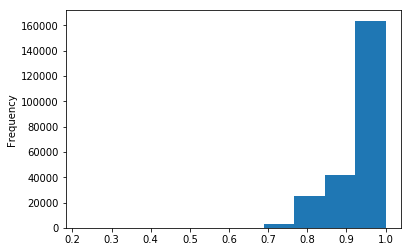

In [23]:
train['titulo_diversity_score'].plot(kind='hist');

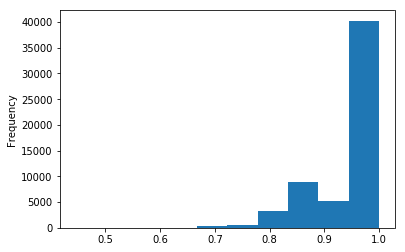

In [24]:
test['titulo_diversity_score'].plot(kind='hist');

In [25]:
train['titulo_cant_caracteres'] = train['titulo'].apply(lambda x: len(x))

test['titulo_cant_caracteres'] = test['titulo'].apply(lambda x: len(x))

In [26]:
import re
train['titulo_cant_signos_puntuacion'] = train['titulo'].apply(lambda x: len(re.split("['.', ',', '!', '?', '¿', '¡', '-']",x)))

test['titulo_cant_signos_puntuacion'] = test['titulo'].apply(lambda x: len(re.split("['.', ',', '!', '?', '¿', '¡', '-']",x)))

In [27]:
# source: https://stackoverflow.com/a/2979208
import math

def entropy(string):
        "Calculates the Shannon entropy of a string"

        # get probability of chars in string
        prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list(string)) ]

        # calculate the entropy
        entropy = - sum([ p * math.log(p) / math.log(2.0) for p in prob ])

        return entropy

In [28]:
train['titulo_entropy'] = train['titulo'].apply(lambda x: entropy(x))

test['titulo_entropy'] = test['titulo'].apply(lambda x: entropy(x))

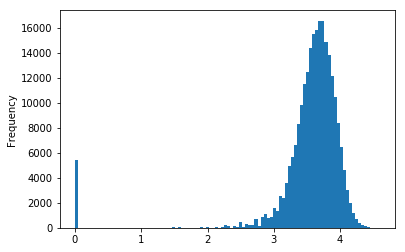

In [29]:
train['titulo_entropy'].plot(kind='hist',bins=100);

In [30]:
train['titulo_mean_word_length'] = train['titulo'].apply(lambda x: np.mean([len(word) for word in x.split()] if x.split() else np.nan))

test['titulo_mean_word_length'] = test['titulo'].apply(lambda x: np.mean([len(word) for word in x.split()] if x.split() else np.nan))

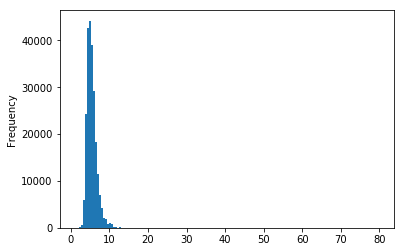

In [31]:
train['titulo_mean_word_length'].plot(kind='hist',bins=150)

## Descripcion

In [32]:
train['descripcion'].fillna("", inplace=True)

train['descripcion_cant_html_tags'] = train['descripcion'].apply(lambda x: len(x.split('<'))-1)

test['descripcion'].fillna("", inplace=True)

test['descripcion_cant_html_tags'] = test['descripcion'].apply(lambda x: len(x.split('<'))-1)

In [33]:
train[['descripcion']].sample(5)

,descripcion
206240,<p>la paz departamento nuevo en venta parck 14...
236262,"<p>departamentos, alborada 1 - parque del pedr..."
162693,"-- -- casa en excelentes condiciones, orig..."
204528,estrene departamento de lujo en capitolio nuev...
218223,"casa residencial en venta, excelente oportunid..."


In [34]:
train['descripcion_cant_palabras'] = train['descripcion'].apply(lambda x: len(x.split()))

test['descripcion_cant_palabras'] = test['descripcion'].apply(lambda x: len(x.split()))

In [35]:
train['descripcion_cant_palabras_unicas'] = train['descripcion'].apply(lambda x: len(set(x.split())))

test['descripcion_cant_palabras_unicas'] = test['descripcion'].apply(lambda x: len(set(x.split())))

In [36]:
# Concepto traido de https://docs.featuretools.com/generated/nlp_primitives.DiversityScore.html#nlp_primitives.DiversityScore
# Cito de la doc oficial:
#         Given a list of strings, calculates the total number of unique words divided by the total number of words
#         in order to give the text a score from 0-1 that indicates how unique the words used in it are.

train['descripcion_diversity_score'] = train['descripcion_cant_palabras_unicas']/train['descripcion_cant_palabras']

test['descripcion_diversity_score'] = test['descripcion_cant_palabras_unicas']/test['descripcion_cant_palabras']

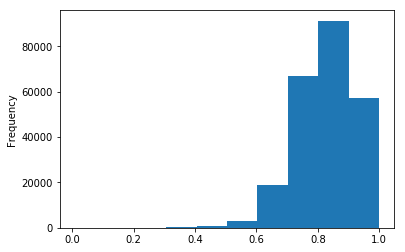

In [37]:
train['descripcion_diversity_score'].plot(kind='hist');

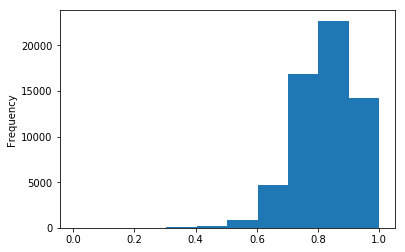

In [38]:
test['descripcion_diversity_score'].plot(kind='hist');

In [39]:
train['descripcion_cant_caracteres'] = train['descripcion'].apply(lambda x: len(x))

test['descripcion_cant_caracteres'] = test['descripcion'].apply(lambda x: len(x))

In [40]:
import re
train['descripcion_cant_signos_puntuacion'] = train['descripcion'].apply(lambda x: len(re.split("['.', ',', '!', '?', '¿', '¡', '-']",x)))

test['descripcion_cant_signos_puntuacion'] = test['descripcion'].apply(lambda x: len(re.split("['.', ',', '!', '?', '¿', '¡', '-']",x)))

In [41]:
# source: https://stackoverflow.com/a/2979208
import math

def entropy(string):
        "Calculates the Shannon entropy of a string"

        # get probability of chars in string
        prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list(string)) ]

        # calculate the entropy
        entropy = - sum([ p * math.log(p) / math.log(2.0) for p in prob ])

        return entropy

In [42]:
train['descripcion_entropy'] = train['descripcion'].apply(lambda x: entropy(x))

test['descripcion_entropy'] = test['descripcion'].apply(lambda x: entropy(x))

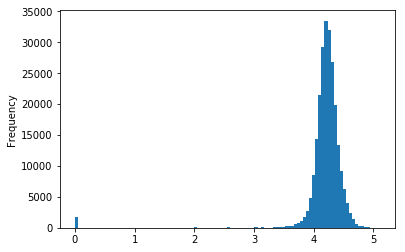

In [43]:
train['descripcion_entropy'].plot(kind='hist',bins=100);

In [44]:
train['descripcion_mean_word_length'] = train['descripcion'].apply(lambda x: np.mean([len(word) for word in x.split()] if x.split() else np.nan))

test['descripcion_mean_word_length'] = test['descripcion'].apply(lambda x: np.mean([len(word) for word in x.split()] if x.split() else np.nan))

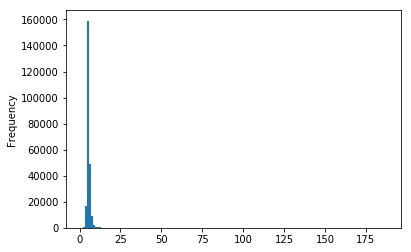

In [46]:
train['descripcion_mean_word_length'].plot(kind='hist',bins=150)

# Veamos que queda...

In [47]:
train.shape

(240000, 91)

In [48]:
train.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio', 'cant_amenities', 'year',
       'sin_month', 'cos_month', 'sin_day', 'cos_day', 'sin_dayofweek',
       'cos_dayofweek', 'sin_dayofyear', 'cos_dayofyear', 'daysinmonth',
       'is_leap_year', 'is_month_end', 'is_month_start', 'is_quarter_end',
       'is_quarter_start', 'is_year_end', 'is_year_start', 'sin_weekofyear',
       'cos_weekofyear', 'reatio_cubiertos_totales',
       'gimnasio_AND_usosmultiples', 'gimnasio_OR_usosmultiples',
       'gimnasio_XOR_usosmultiples', 'gimnasio_AND_piscina',
       'gimnasio_OR_piscina', 'gimnasio_XOR_piscina',
       'gimnasio_AND_escuelascercanas', 'gimnasio_OR_escuelascercanas',
       'gimnasio_XOR_escuelasce

In [49]:
# train.drop(['titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
#             'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
#             'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
#             'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
#             'centroscomercialescercanos', 'precio'], axis=1).to_csv('../data/feat_eng.csv', index=False)

Se ha intentado guardar el csv, pero como ocupa demasiado espacio, a continuacion se arma una celda para correr todo esto junto y trabajar con esto en memoria directamente.

# Juntando todo...

In [44]:
import pandas as pd
import numpy as np

train = pd.read_csv('../data/train.csv', dtype={'tipodepropiedad':'category', 'ciudad':'category', 'provincia':'category', 'id':'int32', 'antiguedad':'float16', 'habitaciones':'float16', 'garages':'float16', 'banos':'float16', 'metroscubiertos':'float16', 'metrostotales':'float16', 'idzona':'float16', 'lat':'float16', 'lng':'float16', 'gimnasio':'bool', 'usosmultiples':'bool', 'piscina':'bool', 'escuelascercanas':'bool', 'centroscomercialescercanos':'bool'}, parse_dates=['fecha'])
test = pd.read_csv('../data/test.csv', dtype={'tipodepropiedad':'category', 'ciudad':'category', 'provincia':'category', 'id':'int32', 'antiguedad':'float16', 'habitaciones':'float16', 'garages':'float16', 'banos':'float16', 'metroscubiertos':'float16', 'metrostotales':'float16', 'idzona':'float16', 'lat':'float16', 'lng':'float16', 'gimnasio':'bool', 'usosmultiples':'bool', 'piscina':'bool', 'escuelascercanas':'bool', 'centroscomercialescercanos':'bool'}, parse_dates=['fecha'])

rescued_coords = pd.read_csv('../data/rescueLatLongs.csv')

def contar_amenities(row):
    return row['gimnasio'] + row['usosmultiples'] + row['piscina'] + row['escuelascercanas'] + row['centroscomercialescercanos']

train['cant_amenities'] = train.apply(lambda x: contar_amenities(x), axis=1)
test['cant_amenities'] = test.apply(lambda x: contar_amenities(x), axis=1)

def feature_fechas(df):
    # Para entender lo de los senos y cosenos: https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
    df['year'] = df['fecha'].dt.year
    df['month'] = df['fecha'].dt.month
    df['day'] = df['fecha'].dt.day
    df['sin_month'] = np.sin(2*np.pi*df['month']/12)
    df['cos_month'] = np.cos(2*np.pi*df['month']/12)
    # tomo cant. de dias en mes: 31 en todos los casos. Para esto deberia servir bastante bien igual.
    df['sin_day'] = np.sin(2*np.pi*df['day']/31)
    df['cos_day'] = np.cos(2*np.pi*df['day']/31)
    
    df['dayofweek'] = df['fecha'].dt.dayofweek
    df['sin_dayofweek'] = np.sin(2*np.pi*df['dayofweek']/7)
    df['cos_dayofweek'] = np.cos(2*np.pi*df['dayofweek']/7)
    
    df['dayofyear'] = df['fecha'].dt.dayofyear
    df['sin_dayofyear'] = np.sin(2*np.pi*df['dayofyear']/365)
    df['cos_dayofyear'] = np.cos(2*np.pi*df['dayofyear']/365)
    
    
#     df['days_in_month'] = df['fecha'].dt.days_in_month
    df['daysinmonth'] = df['fecha'].dt.daysinmonth
    df['is_leap_year'] = df['fecha'].dt.is_leap_year
    df['is_month_end'] = df['fecha'].dt.is_month_end
    df['is_month_start'] = df['fecha'].dt.is_month_start
    df['is_quarter_end'] = df['fecha'].dt.is_quarter_end
    df['is_quarter_start'] = df['fecha'].dt.is_quarter_start
    df['is_year_end'] = df['fecha'].dt.is_year_end
    df['is_year_start'] = df['fecha'].dt.is_year_start
    
#     df['week'] = df['fecha'].dt.week
    df['weekofyear'] = df['fecha'].dt.weekofyear
    df['sin_weekofyear'] = np.sin(2*np.pi*df['weekofyear']/53)
    df['cos_weekofyear'] = np.cos(2*np.pi*df['weekofyear']/53)
    
    # no necesito mas las cols. originales de month y day.
    df.drop(['month','day','dayofweek','dayofyear','weekofyear'], axis=1, inplace=True)
    
feature_fechas(train)
feature_fechas(test)

import itertools
def two_set_bools(df, bool_features):
    for combination in itertools.combinations(bool_features,2):
        if combination[0] != combination[1]:
            new_feature_name = combination[0] + "_AND_" + combination[1]
            df[new_feature_name] = df[combination[0]] & df[combination[1]]
            
            new_feature_name = combination[0] + "_OR_" + combination[1]
            df[new_feature_name] = df[combination[0]] | df[combination[1]]
            
            new_feature_name = combination[0] + "_XOR_" + combination[1]
            df[new_feature_name] = df[combination[0]] ^ df[combination[1]]

two_set_bools(train, ['gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos'])
two_set_bools(test, ['gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos'])

train['reatio_cubiertos_totales'] = train['metroscubiertos']/train['metrostotales']
test['reatio_cubiertos_totales'] = test['metroscubiertos']/train['metrostotales']

palabras_avenida = ['avenida', 'av']
train['es_avenida'] = train['direccion'].fillna('no info').apply(lambda x: any(avenida_indicator in x.lower() for avenida_indicator in palabras_avenida))
test['es_avenida'] = test['direccion'].fillna('no info').apply(lambda x: any(avenida_indicator in x.lower() for avenida_indicator in palabras_avenida))

train['titulo'].fillna("", inplace=True)

train['titulo_cant_html_tags'] = train['titulo'].apply(lambda x: len(x.split('<'))-1)

test['titulo'].fillna("", inplace=True)

test['titulo_cant_html_tags'] = test['titulo'].apply(lambda x: len(x.split('<'))-1)

train['titulo_cant_palabras'] = train['titulo'].apply(lambda x: len(x.split()))

test['titulo_cant_palabras'] = test['titulo'].apply(lambda x: len(x.split()))

train['titulo_cant_palabras_unicas'] = train['titulo'].apply(lambda x: len(set(x.split())))

test['titulo_cant_palabras_unicas'] = test['titulo'].apply(lambda x: len(set(x.split())))

# Concepto traido de https://docs.featuretools.com/generated/nlp_primitives.DiversityScore.html#nlp_primitives.DiversityScore
# Cito de la doc oficial:
#         Given a list of strings, calculates the total number of unique words divided by the total number of words
#         in order to give the text a score from 0-1 that indicates how unique the words used in it are.

train['titulo_diversity_score'] = train['titulo_cant_palabras_unicas']/train['titulo_cant_palabras']

test['titulo_diversity_score'] = test['titulo_cant_palabras_unicas']/test['titulo_cant_palabras']

train['titulo_cant_caracteres'] = train['titulo'].apply(lambda x: len(x))

test['titulo_cant_caracteres'] = test['titulo'].apply(lambda x: len(x))

import re
train['titulo_cant_signos_puntuacion'] = train['titulo'].apply(lambda x: len(re.split("['.', ',', '!', '?', '¿', '¡', '-']",x)))

test['titulo_cant_signos_puntuacion'] = test['titulo'].apply(lambda x: len(re.split("['.', ',', '!', '?', '¿', '¡', '-']",x)))

# source: https://stackoverflow.com/a/2979208
import math

def entropy(string):
        "Calculates the Shannon entropy of a string"

        # get probability of chars in string
        prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list(string)) ]

        # calculate the entropy
        entropy = - sum([ p * math.log(p) / math.log(2.0) for p in prob ])

        return entropy

train['titulo_entropy'] = train['titulo'].apply(lambda x: entropy(x))

test['titulo_entropy'] = test['titulo'].apply(lambda x: entropy(x))

train['titulo_mean_word_length'] = train['titulo'].apply(lambda x: np.mean([len(word) for word in x.split()] if x.split() else np.nan))

test['titulo_mean_word_length'] = test['titulo'].apply(lambda x: np.mean([len(word) for word in x.split()] if x.split() else np.nan))

train['descripcion'].fillna("", inplace=True)

train['descripcion_cant_html_tags'] = train['descripcion'].apply(lambda x: len(x.split('<'))-1)

test['descripcion'].fillna("", inplace=True)

test['descripcion_cant_html_tags'] = test['descripcion'].apply(lambda x: len(x.split('<'))-1)

train['descripcion_cant_palabras'] = train['descripcion'].apply(lambda x: len(x.split()))

test['descripcion_cant_palabras'] = test['descripcion'].apply(lambda x: len(x.split()))

train['descripcion_cant_palabras_unicas'] = train['descripcion'].apply(lambda x: len(set(x.split())))

test['descripcion_cant_palabras_unicas'] = test['descripcion'].apply(lambda x: len(set(x.split())))

# Concepto traido de https://docs.featuretools.com/generated/nlp_primitives.DiversityScore.html#nlp_primitives.DiversityScore
# Cito de la doc oficial:
#         Given a list of strings, calculates the total number of unique words divided by the total number of words
#         in order to give the text a score from 0-1 that indicates how unique the words used in it are.

train['descripcion_diversity_score'] = train['descripcion_cant_palabras_unicas']/train['descripcion_cant_palabras']

test['descripcion_diversity_score'] = test['descripcion_cant_palabras_unicas']/test['descripcion_cant_palabras']

train['descripcion_cant_caracteres'] = train['descripcion'].apply(lambda x: len(x))

test['descripcion_cant_caracteres'] = test['descripcion'].apply(lambda x: len(x))

import re
train['descripcion_cant_signos_puntuacion'] = train['descripcion'].apply(lambda x: len(re.split("['.', ',', '!', '?', '¿', '¡', '-']",x)))

test['descripcion_cant_signos_puntuacion'] = test['descripcion'].apply(lambda x: len(re.split("['.', ',', '!', '?', '¿', '¡', '-']",x)))

# source: https://stackoverflow.com/a/2979208
import math

def entropy(string):
        "Calculates the Shannon entropy of a string"

        # get probability of chars in string
        prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list(string)) ]

        # calculate the entropy
        entropy = - sum([ p * math.log(p) / math.log(2.0) for p in prob ])

        return entropy

train['descripcion_entropy'] = train['descripcion'].apply(lambda x: entropy(x))

test['descripcion_entropy'] = test['descripcion'].apply(lambda x: entropy(x))

train['descripcion_mean_word_length'] = train['descripcion'].apply(lambda x: np.mean([len(word) for word in x.split()] if x.split() else np.nan))

test['descripcion_mean_word_length'] = test['descripcion'].apply(lambda x: np.mean([len(word) for word in x.split()] if x.split() else np.nan))

del rescued_coords